In [ ]:
# forecast monthly births with xgboost
import numpy as np
import pandas as pd
from keras import backend
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving rohpapier.csv to rohpapier.csv


            Price_Change_rel
BEDAT                       
4/13/2021           0.318841
8/29/2018                NaN
7/1/2019                 NaN
12/10/2019         -0.049383
3/30/2020                NaN
...                      ...
3/27/2019                NaN
6/7/2019           -0.023810
9/3/2019           -0.029268
12/27/2019         -0.030151
3/10/2020                NaN

[1289 rows x 1 columns]


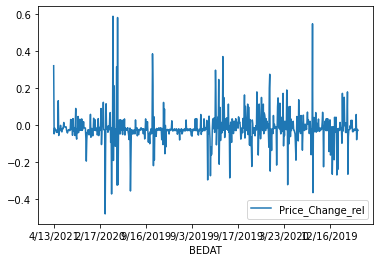

In [ ]:
filename = next(iter(uploaded))
savedfile = filename.split('.')[0]
title = savedfile

# load the dataset
#series = read_csv(filename, header=0, index_col=0, usecols=['MENGE','BEDAT','Price_Change_rel','Last_order_Date'])
series = read_csv(filename, header=0, index_col=0, decimal=',', usecols=['BEDAT','Price_Change_rel'])
print(series)
series.dropna(subset = ["Price_Change_rel"], inplace=True)
#print(series.values)
#values = series.values.astype(float)
series.plot()

In [ ]:
df = read_csv(filename, header=0, index_col=0, decimal=',')
print(df)
df.info()

df['BEDAT'] = df['BEDAT'].astype('datetime64[ns]')
df.info()
print(df.dtypes)

    CompID                        MAKTX Warengruppenbezeichnung  MENGE  \
ID                                                                       
1        1                          NaN               Rohpapier   5436   
7        1  0400 2070 H1793  080   CM -               Rohpapier   2424   
7        1  5500 1030 H1145  065    - -               Rohpapier      0   
7        1  5500 1030 H1145  065    - -               Rohpapier      0   
7        1  5500 1030 H1181  070    - -               Rohpapier      0   
..     ...                          ...                     ...    ...   
7        1  5500 2100 W974   070    - -               Rohpapier  30751   
7        1  5500 2100 W974   070    - -               Rohpapier  15456   
7        1  5500 2100 W974   070    - -               Rohpapier  15213   
7        1  5500 2100 W974   070    - -               Rohpapier   9713   
7        1  5500 2140 W974   070    - -               Rohpapier  10264   

         BEDAT                 NAME1 

            Price_Change_rel
BEDAT                       
2017-08-29               NaN
2018-04-26               NaN
2018-04-30               NaN
2018-05-08               NaN
2018-05-17               NaN
...                      ...
2020-04-23         -0.013680
2020-04-27               NaN
2020-04-29               NaN
2020-04-30         -0.049525
2021-04-13          0.318841

[1289 rows x 1 columns]


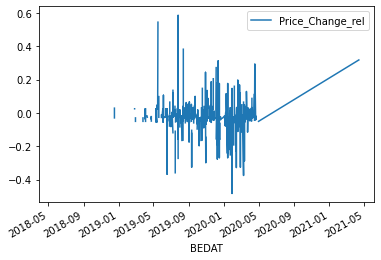

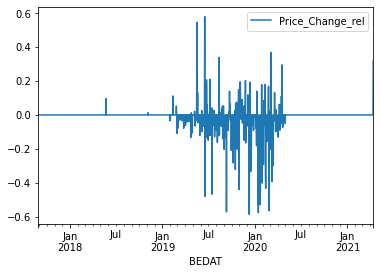

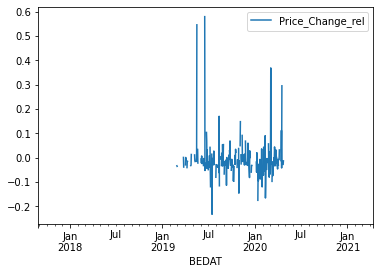

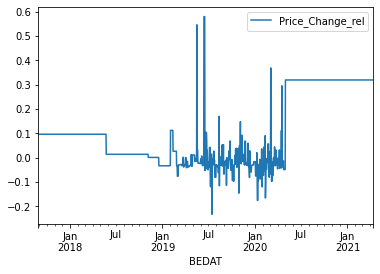

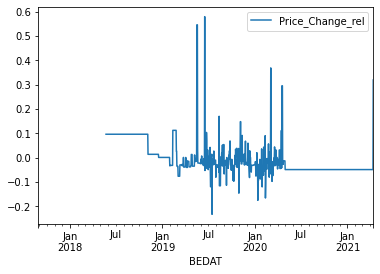

In [ ]:
selected = df[['BEDAT','Price_Change_rel']]
#print(selected)

ds = selected.copy()
#convert to datetime to use it as an index for sorting and visualizing
ds['BEDAT'] = pd.to_datetime(ds['BEDAT'])
#sets a datetime index
ds.set_index('BEDAT', drop=True, append=False, inplace=True, verify_integrity=False)
#sorts datetime values ascending in place
ds.sort_values(by='BEDAT', ascending=True, inplace=True)
print(ds)

ds.plot.line()

ds_up = ds.resample('D').sum()
ds_up.plot.line()

ds_up = ds.resample('D').mean()
ds_up.plot.line()

ds_up = ds.resample('D').mean().bfill()
ds_up.plot.line()

ds_up = ds.resample('D').mean().ffill()
ds_up.plot.line()
#upsampled = series.resample('D')
#print(upsampled)
#upsampled.plot()



In [ ]:
#Getting start and end dates
#max = len(ds_up.index)
print(ds_up.index.min())
print(ds_up.index.max())
start_date = ds_up.index.min()
end_date = ds_up.index.max()

# alternate if index is not set on a date you can use min(df['property']) or max(df['property'])

2017-08-29 00:00:00
2021-04-13 00:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving allfeatures.csv to allfeatures (5).csv


In [ ]:
filename = next(iter(uploaded))
savedfile = filename.split('.')[0]
title = savedfile

# load the dataset
#series = read_csv(filename, header=0, index_col=0, usecols=['MENGE','BEDAT','Price_Change_rel','Last_order_Date'])
features = read_csv(filename, header=0, index_col=0, decimal=',', usecols=['Begin-Date','End-Date','Schädling-TotalFrequency','Schädling-PositiveFrequency','Schädling-NegativeFrequency','Schädling-MeanSentiment','Schädling-SentimentStdDev','GeneralWoodDamage-TotalFrequency','GeneralWoodDamage-PositiveFrequency','GeneralWoodDamage-NegativeFrequency','GeneralWoodDamage-MeanSentiment','GeneralWoodDamage-SentimentStdDev','Wetter-TotalFrequency','Wetter-PositiveFrequency','Wetter-NegativeFrequency','Wetter-MeanSentiment','Wetter-SentimentStdDev','Folgeindustrie-TotalFrequency','Folgeindustrie-PositiveFrequency','Folgeindustrie-NegativeFrequency','Folgeindustrie-MeanSentiment','Folgeindustrie-SentimentStdDev'])
print(features)

              End-Date Schädling-TotalFrequency Schädling-PositiveFrequency  \
Begin-Date                                                                    
1/1/2019      1/1/2019                      NaN                         NaN   
1/2/2019      1/2/2019                     1.00                        4.00   
1/3/2019      1/3/2019                     3.00                        0.00   
1/4/2019      1/4/2019                     3.00                        4.00   
1/5/2019      1/5/2019                      NaN                         NaN   
...                ...                      ...                         ...   
12/27/2021  12/27/2021                      NaN                         NaN   
12/28/2021  12/28/2021                     1.00                        0.00   
12/29/2021  12/29/2021                     2.00                        0.00   
12/30/2021  12/30/2021                     7.00                        0.00   
12/31/2021  12/31/2021                     4.00     

In [ ]:
#features.index

features.index = pd.DatetimeIndex(features.index)
features.index

#weird enough Begin-Date is not in index anymore, as it is the index, therefore we can select the other columns based on the date
selected = features[['End-Date','Schädling-TotalFrequency','Schädling-MeanSentiment','GeneralWoodDamage-TotalFrequency','GeneralWoodDamage-MeanSentiment','Wetter-TotalFrequency','Wetter-MeanSentiment','Folgeindustrie-TotalFrequency','Folgeindustrie-MeanSentiment']]
print(selected)

selected_date = (selected.index > start_date) & (selected.index <= end_date)
selected_rows = selected.loc[selected_date]
selected_rows.fillna(0,inplace=True)
#selected_rows.replace(np.nan, 0)
selected_rows

#feat = selected.copy()
#print(feat)


              End-Date Schädling-TotalFrequency Schädling-MeanSentiment  \
Begin-Date                                                                
2019-01-01    1/1/2019                      NaN                     NaN   
2019-01-02    1/2/2019                     1.00                   -0.06   
2019-01-03    1/3/2019                     3.00                   -0.97   
2019-01-04    1/4/2019                     3.00                    0.01   
2019-01-05    1/5/2019                      NaN                     NaN   
...                ...                      ...                     ...   
2021-12-27  12/27/2021                      NaN                     NaN   
2021-12-28  12/28/2021                     1.00                   -0.70   
2021-12-29  12/29/2021                     2.00                   -0.55   
2021-12-30  12/30/2021                     7.00                   -0.51   
2021-12-31  12/31/2021                     4.00                   -0.62   

           GeneralWoodDa

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,End-Date,Schädling-TotalFrequency,Schädling-MeanSentiment,GeneralWoodDamage-TotalFrequency,GeneralWoodDamage-MeanSentiment,Wetter-TotalFrequency,Wetter-MeanSentiment,Folgeindustrie-TotalFrequency,Folgeindustrie-MeanSentiment
Begin-Date,,,,,,,,,
2019-01-01,1/1/2019,0,0,1.00,0.00,0,0,1.00,0.60
2019-01-02,1/2/2019,1.00,-0.06,1.00,-0.41,1.00,0.73,0,0
2019-01-03,1/3/2019,3.00,-0.97,0,0,0,0,1.00,0.00
2019-01-04,1/4/2019,3.00,0.01,1.00,-0.22,5.00,0.14,0,0
2019-01-05,1/5/2019,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2021-04-09,4/9/2021,20.00,-0.27,3.00,-0.17,0,0,5.00,0.16
2021-04-10,4/10/2021,10.00,0.21,5.00,-0.15,1.00,-1.00,1.00,0.00
2021-04-11,4/11/2021,2.00,0.34,1.00,0.00,2.00,0.00,6.00,-0.14


In [ ]:
merged = pd.merge(ds_up,selected_rows,how='inner',left_index=True, right_index=True)
merged

,Price_Change_rel,End-Date,Schädling-TotalFrequency,Schädling-MeanSentiment,GeneralWoodDamage-TotalFrequency,GeneralWoodDamage-MeanSentiment,Wetter-TotalFrequency,Wetter-MeanSentiment,Folgeindustrie-TotalFrequency,Folgeindustrie-MeanSentiment
2019-01-01,0.000428,1/1/2019,0,0,1.00,0.00,0,0,1.00,0.60
2019-01-02,0.000428,1/2/2019,1.00,-0.06,1.00,-0.41,1.00,0.73,0,0
2019-01-03,0.000428,1/3/2019,3.00,-0.97,0,0,0,0,1.00,0.00
2019-01-04,0.000428,1/4/2019,3.00,0.01,1.00,-0.22,5.00,0.14,0,0
2019-01-05,0.000428,1/5/2019,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2021-04-09,-0.049525,4/9/2021,20.00,-0.27,3.00,-0.17,0,0,5.00,0.16
2021-04-10,-0.049525,4/10/2021,10.00,0.21,5.00,-0.15,1.00,-1.00,1.00,0.00
2021-04-11,-0.049525,4/11/2021,2.00,0.34,1.00,0.00,2.00,0.00,6.00,-0.14
2021-04-12,-0.049525,4/12/2021,9.00,-0.09,1.00,-0.67,1.00,0.00,6.00,0.54


In [ ]:
from google.colab import files

#we compute rolling means for sentiment, as people may react with a certain delay to current news

#inplace set to False makes sure that this does not affect the df
#min_periods set to 1 in combination with fillna makes sure that we can compute the correct rolling average once we have at least one value
merged['rolling-Schädling-MeanSentiment']= merged['Schädling-MeanSentiment'].rolling(3,center=True,min_periods=1).mean().fillna(value=0,inplace=False)
merged['rolling-GeneralWoodDamage-MeanSentiment']= merged['GeneralWoodDamage-MeanSentiment'].rolling(3,center=True,min_periods=1).mean().fillna(value=0,inplace=False)
merged['rolling-Wetter-MeanSentiment']= merged['Wetter-MeanSentiment'].rolling(3,center=True,min_periods=1).mean().fillna(value=0,inplace=False)
merged['rolling-Folgeindustrie-MeanSentiment']= merged['Folgeindustrie-MeanSentiment'].rolling(3,center=True,min_periods=1).mean().fillna(value=0,inplace=False)

merged

merged.to_csv('merged.csv', encoding = 'utf-8-sig') 
files.download('merged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>